In [1]:
import os
from importlib import reload
os.chdir('/nfs/slac/g/ki/ki19/deuce/AEGIS/ismael/WLD')

%matplotlib inline 

import mycode
reload(mycode);

In [2]:
from mycode import money
from mycode import preamble
from mycode import weights 
from mycode import maps 

from tqdm import tqdm 

%run mycode/preamble.py

reload(weights)
reload(preamble)
reload(maps)
reload(money);

In [3]:
import astroML
import subprocess
from astroML.plotting import scatter_contour

In [4]:
from astropy.table import Table

In [5]:
data_dir = '/nfs/slac/g/ki/ki19/deuce/AEGIS/ismael/WLD/data'

# Read catalogues 

In [36]:
#filters to apply as reading the catalogue. 
pfilters = [
    maps.get_non_duplicated_cat
]

#filters to be applied uniformly ignoring the selection effect. 
afilters=[
    maps.get_not_dropped_cat, #does not commute with the other ones, so do first. 
    maps.not_dropped, #redundant. 
    maps.low_cond,
]


ffilters = [
    maps.good, 
    maps.best,
]

In [37]:
pcats = [
        Table.read(f"{data_dir}/fprojectLSST-g1_-20-g2_0/final_fits.fits"), 
        Table.read(f"{data_dir}/fprojectLSST-g1_-15-g2_0/final_fits.fits"), 
        Table.read(f"{data_dir}/fprojectLSST-g1_-10-g2_0/final_fits.fits"), 
        Table.read(f"{data_dir}/fprojectLSST-g1_-5-g2_0/final_fits.fits"),
        Table.read(f"{data_dir}/fprojectLSST-g1_0-g2_0/final_fits.fits"), 
        Table.read(f"{data_dir}/fprojectLSST-g1_5-g2_0/final_fits.fits"), 
        Table.read(f"{data_dir}/fprojectLSST-g1_10-g2_0/final_fits.fits"), 
        Table.read(f"{data_dir}/fprojectLSST-g1_15-g2_0/final_fits.fits"), 
        Table.read(f"{data_dir}/fprojectLSST-g1_20-g2_0/final_fits.fits")
        ]

In [38]:
cats = maps.get_filter_cats(pcats, pfilters) 
[len(cat) for cat in cats]

[802149, 802075, 802121, 802182, 802101, 802074, 802166, 802013, 802031]

In [39]:
fcats = [Table.read( f"data/fcats/fcat{i}.fits") for i in range(9)]
[len(cat) for cat in fcats]

[112574, 112574, 112574, 112574, 112574, 112574, 112574, 112574, 112574]

# Histograms of ab_mag

In [12]:
def histograms_abmag(cat,good):
    plt.rc('text', usetex=True)
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    
    

    plt.hist(cat['ab_mag'], histtype='step', bins=18,color='blue',label='all galaxies',range=(20,29))
    plt.hist(good['ab_mag'], histtype='step',bins=18,color='red',label='lensing sample galaxies',range=(20,29))

    labels = [r'$0$',r'$10$',r'$20$',r'$30$',r'$40$']
    values = [0,10,20,30,40]
    conversion = 3600
    y = [value*conversion for value in values]
    plt.yticks(y, labels)
    
    
    plt.xlim((20,29))
    plt.ylabel(r'\rm Galaxies / sq. arcmin. / (0.5 mag)', fontsize=25)
    plt.xlabel(r'\rm Catalog AB magnitude',fontsize=25)
#     plt.title('Histogram of ab_mag for good galaxies')
    plt.legend(loc=2,prop={'size':20})
    plt.axvline(25.3,color='goldenrod',label='cut for golden sample') #this represents the gold sample cut.
    plt.xticks(size=20)
    plt.yticks(size=20)
#     ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
    ax.get_yaxis().get_offset_text().set_size(1)

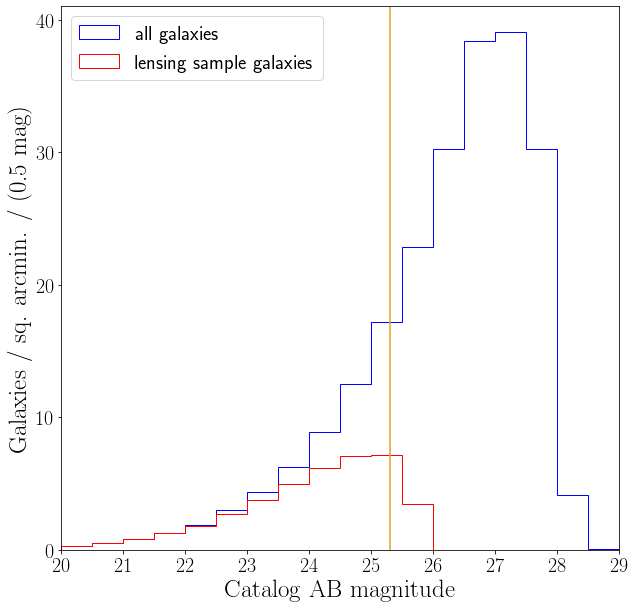

In [13]:
histograms_abmag(cats[4], maps.good(cats[4]))

# Scatter plot 

In [43]:
#produce different plots with the biases calculated from the fisher formalism. 
plt.rc('text', usetex=True)
#matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]


def purity_snr_scatter_final(fraction,analyze_cat,colors,power,full_cat,ax,name,save=None):
    #divide into 4 groups 

    high_pur_high_snr = maps.up_cut(maps.up_cut(analyze_cat,'purity',.98),'snr_grpf',6)
    high_pur_low_snr = maps.down_cut(maps.up_cut(analyze_cat,'purity',.98),'snr_grpf',6)
    low_pur_high_snr = maps.up_cut(maps.down_cut(analyze_cat,'purity',.98),'snr_grpf',6)
    low_pur_low_snr = maps.down_cut(maps.down_cut(analyze_cat,'purity',.98),'snr_grpf',6)
    
    #calculate percentages 
    p1 = float(len(high_pur_high_snr))/len(analyze_cat)
    p2 = float(len(high_pur_low_snr))/len(analyze_cat)
    p3 = float(len(low_pur_high_snr))/len(analyze_cat)
    p4 = float(len(low_pur_low_snr))/len(analyze_cat)
    
    #create smaller catalogues to plot them and reduce the density of points in each region. 
    small_hphs = maps.small(high_pur_high_snr,int(len(high_pur_high_snr)* fraction))
    small_hpls = maps.small(high_pur_low_snr,int(len(high_pur_low_snr)* fraction))
    small_lphs = maps.small(low_pur_high_snr,int(len(low_pur_high_snr) * fraction))
    small_lpls = maps.small(low_pur_low_snr,int(len(low_pur_low_snr)* fraction))

    x_new_ticks = [6,12,18,24,30]
    tex_x_new_ticks = [r'$6$',r'$12$',r'$18$',r'$24$',r'$30$']

    y_orig_ticks = np.array([0.,0.142,0.5402,.785,1])
    y_new_ticks = []
    for label in y_orig_ticks: 
        y_new_ticks.append(r'${:.2g}$'.format(label**(1./12)))
    
    #plot each group separately with different colors 
    #replace original ticks with of new ones. Do that for all. 
    plt.scatter(small_hphs['snr_grpf'],small_hphs['purity']**(power),alpha=.2,color=colors[0])
    plt.yticks(y_orig_ticks, y_new_ticks)
    plt.xticks(x_new_ticks, tex_x_new_ticks)
    
    plt.scatter(small_hpls['snr_grpf'],small_hpls['purity']**(power),alpha=.2,color=colors[1])
    plt.yticks(y_orig_ticks, y_new_ticks)
    plt.xticks(x_new_ticks, tex_x_new_ticks)

    plt.scatter(small_lphs['snr_grpf'],small_lphs['purity']**(power),alpha=.2,color=colors[2])
    plt.yticks(y_orig_ticks, y_new_ticks)
    plt.xticks(x_new_ticks, tex_x_new_ticks)
    
    plt.scatter(small_lpls['snr_grpf'],small_lpls['purity']**(power),alpha=.2,color=colors[3])
    plt.yticks(y_orig_ticks, y_new_ticks)
    plt.xticks(x_new_ticks, tex_x_new_ticks)

    #annotate with colors the percentages
    plt.annotate("{0:.1f}\%".format(p1*100), xy=(0.540, 0.885), xycoords='axes fraction',color='black',fontsize=30)
    plt.annotate("{0:.1f}\%".format(p2*100), xy=(0.040, 0.885), xycoords='axes fraction',color='black',fontsize=30)
    plt.annotate("{0:.1f}\%".format(p3*100), xy=(0.540, 0.4), xycoords='axes fraction',color='black',fontsize=30)
    plt.annotate("{0:.1f}\%".format(p4*100), xy=(0.040, 0.4), xycoords='axes fraction',color='black',fontsize=30)
    plt.text(.380,.01,r'Fraction of full catalogue:${0:.1f}$\%'.format(float(len((analyze_cat)))/len(full_cat)*100),transform=ax.transAxes,fontsize=25)
    
    

    plt.xlabel(r'$\nu_{\rm grpf}$',fontsize=40)
    plt.ylabel(r'$\rho$',fontsize=40)
    plt.tick_params(axis='x', which='major',labelsize=25,size=10,width=3)
    plt.tick_params(axis='y', which='major',labelsize=25,size=10,width=3)
    plt.xlim(0,30)
    plt.ylim(0.,1.)
    #plt.title(name)

(0, 30)

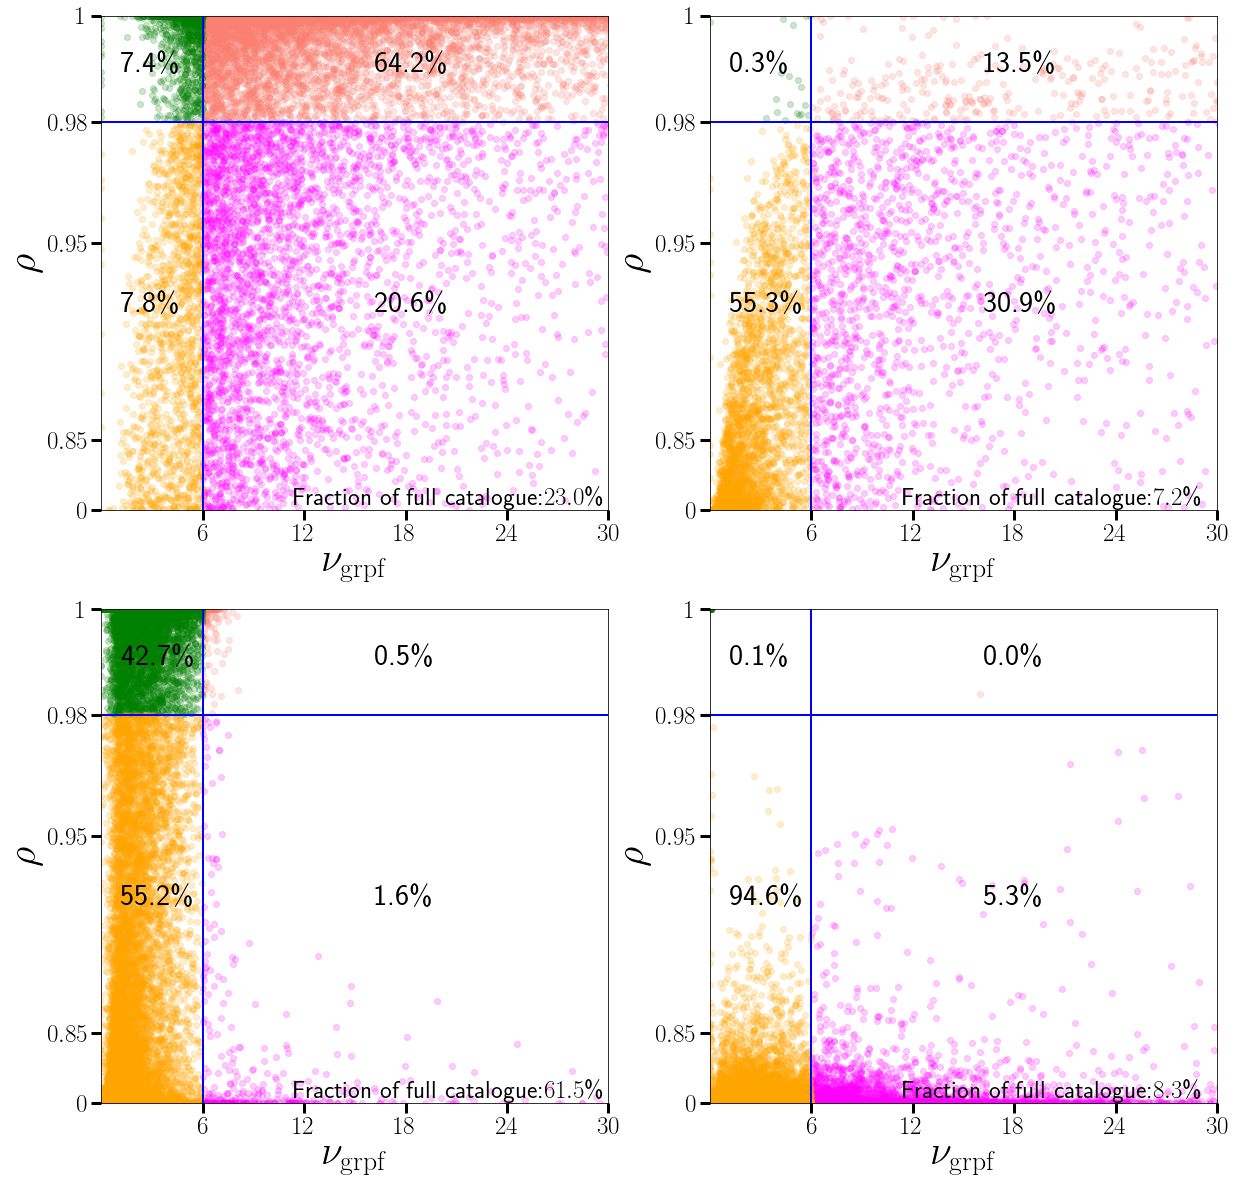

In [44]:
fig = plt.figure(figsize=(20,20))
nrow,ncol = 2,2
power = 12. 
scatter_cat = cats[4]

analyze_cats=[maps.detc_and_notambig(scatter_cat),maps.detc_and_ambig(scatter_cat),maps.notdetc_and_notambig(scatter_cat),
       maps.notdetc_and_ambig(scatter_cat)]
names = ['detc_and_notambig','detc_and_ambig','notdetc_and_notambig','notdetc_and_ambig']
colors= ['salmon', 'green', 'magenta', 'orange','black']
fractions = [1/10.,1./10, 1./20, 1.] #exclusively for plotting purposes

for i,(name,temp_cat,fraction) in enumerate(zip(names,analyze_cats,fractions)):
    ax = plt.subplot(nrow, ncol, i+1)
    plt.axhline(.98**power,color='blue',linewidth=2)
    plt.axvline(6,color='blue',linewidth=2)
    purity_snr_scatter_final(fraction, temp_cat,colors,power,scatter_cat,ax,name)
    #as reference for debugging, 

plt.xlim(0,30)

#  Numbers in text 

In [ ]:
cat = cats[4]
fcat = fcats[4]
good_cat = maps.good(cat)
not_dropped_cat = maps.get_not_dropped_cat(cat) 


In [56]:

############################
x = len(cat[(cat['snr_grpf'] > 6)&(cat['purity'] > 0.98)]) / len(cat)
print("Total fraction of events that are detectable and have high purity: {:.3g}% \n".format(x*100))

x1 = (len(cat) - len(not_dropped_cat)) / len(cat)
y1 = (len(set(cat['grp_id'])) - len(set(not_dropped_cat['grp_id']))) / len(set(cat['grp_id']))
print("{:.3g}% of galaxies are parts of groups with at least one galaxy dropped, \
{:.3g}% of groups have at least one dropped galaxy. \n".format(x1*100, y1*100))

x = len(maps.good(cat)) /len(cat)
print("{:.3g}% of galaxies satisfy criteria for lensing sample. \n".format(x*100))

x1 = len(maps.detected(good_cat)) / len(good_cat)
y1 = len(maps.detc_and_notambig(good_cat)) / len(good_cat)
y2 = len(maps.detc_and_ambig(good_cat)) / len(good_cat)
x2 = 1 - x1 
y3 = len(maps.notdetc_and_notambig(good_cat)) / len(good_cat)
y4 = len(maps.notdetc_and_ambig(good_cat)) / len(good_cat)
print("Out of the galaxies that satisfy the criteria for the lensing sample, {:.3g}% are detected -- {:.3g}% \
with no close overlaps and {:.3g}% with close overlaps; {:.3g}% are not detected -- {:.3g}% with no close overlaps \
and {:.3g}% with close overlaps. \n ".format(x1*100, y1*100, y2*100, x2*100, y3*100, y4*100))

x = len(fcat) / len(cat)
print("{:.3g}% will be used for fisher analysis, or {:.3g} of galaxies".format(x*100, len(fcat)))



Total fraction of events that are detectable and have high purity: 16% 

0.259% of galaxies are parts of groups with at least one galaxy dropped, 0.0525% of groups have at least one dropped galaxy. 

18.1% of galaxies satisfy criteria for lensing sample. 

Out of the galaxies that satisfy the criteria for the lensing sample, 93.2% are detected -- 77.9% with no close overlaps and 15.4% with close overlaps; 6.79% are not detected -- 4.79% with no close overlaps and 2% with close overlaps. 
 
14% will be used for fisher analysis, or 1.13e+05 of galaxies


In [26]:
len(cat)

802101

In [25]:
len(not_dropped_cat)

800027

In [53]:
(len(maps.good(maps.best(maps.low_cond(not_dropped_cat)))) - 112574) / 112574

0.0023628901877875887